### The notebook inspects the top 10 replies coordination strategy

In [1]:
## Replies to external

In [2]:
import pandas as pd
import numpy as np
import warnings
import datetime
import gzip
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from tqdm import tqdm
from random import sample
import itertools
import difflib
import json
import sys
import os
from scipy.stats import ks_2samp, mannwhitneyu, wilcoxon
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
# from fitter import Fitter
from importlib import reload

sys.path.insert(0, 
                '/geode2/home/u070/potem/Carbonate/Projects/infoOps-strategy/script/helper')
from strategy_helper import *
from visualization import *
from helper import *

In [3]:
path = '/N/slate/potem/data/derived'
all_data = '/N/slate/potem/YYYY_MM'
plot_path = '/N/u/potem/Quartz/project/infoOps-strategy/plots'
save_path = '/N/slate/potem/data/derived/combined'
control_file = 'control_driver_users.csv'

In [4]:
campaigns = {
    # '2021_12': ['Venezuela_0621', ],
    '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                'uganda_0621', 'Venezuela_0621'],
    '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 'iran_202012'],
    '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
    '2020_08': ['cuba_082020', 'qatar_082020'],
}

In [5]:
all_campaigns = {
    '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                'uganda_0621', 'Venezuela_0621'],
    '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 
                'iran_202012'],
    '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
    '2020_08': ['cuba_082020', 'qatar_082020'],
    
    '2020_05' : [
                 'china_052020', 
                 'turkey_052020',
                 'russia_052020' #incomplete control data
                ],
    '2020_04' : ['egypt_022020', 'honduras_022020',
                 'indonesia_022020', 'sa_eg_ae_022020',
                 'serbia_022020'],
    '2020_03': ['ghana_nigeria_032020'],
    '2019_11': ['saudi_arabia_112019'],
    '2019_08': ['china_082019', 'china_082019_2', 'china_082019_3',
                'ecuador_082019_1', 'egypt_uae_082019_1', 
                'saudi_arabia_082019_1', 'spain_082019_1',
                'uae_082019_1'],
    '2019_06': ['catalonia_201906_1',
                'russia_201906_1',
                'iran_201906_1',
                'iran_201906_2',
                'iran_201906_3',
                'venezuela_201906_1'
               ],
    '2019_01': ['iran_201901_1', 
                'russia_201901_1',
                'bangladesh_201901_1',
                'venezuela_201901_1',
                'venezuela_201901_2'
               ],
    '2018_10': ['ira', 'iranian'],
}

In [6]:
# for year in all_campaigns:
#     for new_campaign in all_campaigns[year]:
#         print(f'\n ------ {new_campaign} ------- \n')
        
#         ops_file_path = os.path.join(path, 'all_tweets', year, 
#                                new_campaign, f'{new_campaign}_tweets.pkl.gz')
#         control_file_path = os.path.join(path, 'all_tweets', year, 
#                                 campaign, 'DriversControl', 
#                                 f'{campaign}_control.pkl.gz')
        
#         data_new = read_ops_control_data(ops_file_path, 
#                                      control_file_path, 
#                                      ['ops'])

# Visualization

In [6]:
def single_plot(parameters):
    if 'size' in parameters:
        size = parameters['size']
    else:
        size = (10, 10)
        
    fig, ax = plt.subplots(figsize=size)
        
    fontsize = 14
    colors = ['red', 'blue', 'orange', 'red', 'olive', 
              'pink', 'lime', 'maroon']
    x_index = np.arange(len(data))
    
    
    x_label = parameters['xlabel']
    y_label = parameters['ylabel']
    title = parameters['title']
    plot_path = parameters['save']['path']
    filename = parameters['save']['filename']
    
    for index, df in enumerate(parameters['data']):
        x = parameters['columns'][index]['x']
        y = parameters['columns'][index]['y']
        label = parameters['columns'][index]['label']
        
        ax.plot(df[x], 
                df[y],
                color=colors[index],
                label=label,
                linewidth=2,
               )
        
       
        # ax.axhline(round(data[key].mean(), 2),
        #            color=colors[i],
        #            linewidth=2
        #           )
        # ax.axhline(round(data[key].median(), 2),
        #            color=colors[i],
        #            marker='+',
        #            linewidth=5
        #           )
        
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.set_xlabel(x_label, fontsize=fontsize)
        
        # new_axis.set_xticks(x_index, data[x])
        # new_axis.set_xlabel('Time (Year-month)', 
        # fontsize=fontsize)
        
    ax.tick_params(axis='both', which='both', 
                       labelsize=8, labelbottom=True)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

    ax.legend(loc="upper right", 
              frameon=True, 
              fontsize=fontsize)
    ax.set_title(f'{title}')
    ax.tick_params(axis='x', labelrotation=90)
    
    plt.xticks(rotation = 90)
    plt.title(title)
        
    plt.show()
    
    fig.savefig(f'{plot_path}/{filename}.png', 
          facecolor='white', 
          transparent=False)
    

def ccdf_symbol(parameters):
    '''
    Plots ccdf for data with symbols
    
    :param parameters: parameters to set for the plot
    '''
    
    # {
    #     'data': df,
    #     'fontsize': 14,
    #     'complementary': True,
    #     'columns': [
    #         {'column': ''
    #          'label': '',
    #         },{
    #         'column': '',
    #          'label': ''
    #         }
    #     ],
    #     'xlabel': '',
    #     'ylabel': '',
    #     'legend_location': '',
    #     'log_yscale': True,
    #     'log_xscale': True,
    #     'save': {
    #         'path': '',
    #         'filename': ''
    #     },
        # 'random_color': False
    # }
    
    keys = parameters.keys()
    if 'size' in parameters:
        size = parameters['size']
    else:
        size = (8, 8)
    fig, ax = plt.subplots(figsize=size)
    fontsize = parameters['fontsize']
    colors = ['red', 'blue', 'green', 'orange', 
              'olive', 'pink', 'lime', 'maroon']
    total_columns = len(parameters['columns'])
    
    if parameters['random_color'] == True:
        all_colors =  [k for k,v in pltc.cnames.items()]
        colors = get_cmap(total_columns)
        # colors = sample(all_colors, total_columns)
        
    
    symbols = ['.', 'o', '+', 'x', '*', 'v', '^', '>']
    
    marker = itertools.cycle(symbols) 
    
    # for n in y:
    #     plt.plot(x,n, marker = marker.next(), linestyle='')

    
    i = 0
    cmap = plt.cm.get_cmap('hsv', total_columns)
    
    for data in parameters['data']:
        column = parameters['columns'][i]['column']
        data = parameters['data'][i][column]
        label = parameters['columns'][i]['label']
        
        if i == 15:
            sns.ecdfplot(data, 
                     complementary=parameters['complementary'],
                     label=label,
                     marker=symbols[3],
                     color='red',
                     ax=ax,
                     # linewidth=1,
                        )
        elif i == 11:
            sns.ecdfplot(data, 
                     complementary=parameters['complementary'],
                     label=label,
                     marker=symbols[1],
                     color='blue',
                     ax=ax,
                     # linewidth=1,
                        )
        else:
            sns.ecdfplot(data, 
                         complementary=parameters['complementary'],
                         label=label,
                         marker=next(marker),
                         color=colors(i),
                         ax=ax,
                         # linewidth=1,
                        )

        i = i + 1
        
    ax.set_xlabel(parameters['xlabel'], 
                  fontsize=fontsize)
    ax.set_ylabel(parameters['ylabel'], 
                  fontsize=fontsize)

    ax.tick_params(axis='both', labelsize=fontsize) 
    
    if 'legend_location' in keys:
        ax.legend(loc=parameters['legend_location'], 
                  frameon=True, fontsize=fontsize)
        
    if 'legend_lower' in keys:
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.2,
                         box.width, box.height * 0.9])

        # Put a legend below current axis
        ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, 
                  shadow=True, ncol=3)
    
    if 'log_yscale' in keys:
        ax.set_yscale('log')
    if 'log_xscale' in keys:
        ax.set_xscale('log')
        
    if 'title' in keys:
        plt.title(parameters['title'])

    if 'save' in keys:
        path = parameters['save']['path']
        filename = parameters['save']['filename']
        
        fig.savefig(f'{path}/{filename}', 
              facecolor='white', 
              transparent=False)
        
    plt.show()
    

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

### Functions

In [7]:
def replies_to_tweet_ratio(df, outsider = True):
    '''
    Get replies to tweet ratio for each user in dataset
    
    :param df: dataframe
    :param outsider: Boolean to specify to include only reply to users
    outside the dataset
    '''
    
    df = df.fillna(0)
    
    df = df.astype({
        'in_reply_to_userid': int,
        'in_reply_to_tweetid': int
    })

    df_replies = df.loc[~(df['in_reply_to_tweetid'] == 0)]
    
    #userid not in the data (outside accounts)
    if outsider == True:
        df_replies = df_replies.loc[
            ~(df_replies['in_reply_to_userid'].isin(df['userid']))]
                       
    df_replies_grp = (df_replies.groupby(['userid'])['tweetid']
                      .size()
                      .to_frame('count_replies')
                      .reset_index())
    
    #total activity
    df_all = (df.groupby(['userid'])['tweetid']
                      .size()
                      .to_frame('count')
                      .reset_index())
    
    df_grp_new = df_replies_grp.merge(df_all, on='userid')
    
    df_grp_new['per_replies'] = round(df_grp_new['count_replies']/df_grp_new['count'] * 100, 
                                      2)
    
    return df_grp_new
    
    
def filter_tweets(df, threshold=10):
    #filter out all the users with less than 10 tweets (any actions)
    # df = df.drop_duplicates()
    
    if threshold is not None:
        userids = (df.groupby(['userid'])['tweetid']
                   .size()
                   .to_frame('count')
                   .reset_index()
                   .query(f'count > {threshold}')
                  )['userid']

        df = df.loc[df['userid'].isin(userids)]
    
    return df


def count_reply_external(df):
    '''
    Return the count of replies done to external userid
    
    :param df: dataframe
    '''
    
    df = df.fillna(0)
    df_replies = df.loc[~(df['in_reply_to_tweetid'] == 0)]

    df_replies = df.loc[~(df['in_reply_to_userid'].isin(df['userid']))]
                       
    df_replies_grp = (df_replies.groupby(['userid'])['tweetid']
                      .size()
                      .to_frame('count_replies')
                      .reset_index())
    
    return df_replies_grp

  
def per_month_activity(df, 
                       columns=['tweet_time_month', 'userid'],
                       outsider=True
                      ):
    '''
    Calculates the average reply activity in month
    
    :param df: dataframe
    :param column: time column in dataframe
    '''
    
    df = df.fillna(0)
    df_grp = (df.groupby(columns)
              .size()
              .to_frame('count')
              .reset_index())
    
    df_replies = df.loc[~(df['in_reply_to_tweetid'] == 0)]
    
    
    if outsider == True:
        df_replies = df.loc[~(df['in_reply_to_userid'] == 0) & ~(df['in_reply_to_userid'].isin(df['userid']))]
                       
    df_replies_grp = (df_replies.groupby(columns)['tweetid']
                      .size()
                      .to_frame('count_replies')
                      .reset_index())
    
    df_replies_grp = df_replies_grp.merge(df_grp, 
                                      on=columns, 
                                      how='outer')
    
    df_replies_grp['ratio_reply'] = df_replies_grp['count_replies'] / df_replies_grp['count']

    df_replies_grp['ratio_reply'] = df_replies_grp['ratio_reply'].apply(
        lambda x: round(x, 2))
    
    if len(columns) > 1:
        df_per_month = (df_replies_grp.groupby(['tweet_time_month'])['ratio_reply']
                       .mean()
                       .to_frame('mean_ratio_reply')
                       .reset_index())
    else:
        df_per_month = df_replies_grp
    
    df_per_month['tweet_time_month'] = df_per_month['tweet_time_month'].astype(str)

    df_per_month = df_per_month.fillna(0)
    
    return df_per_month


def convert_string_mention_to_list(df, column='user_mentions'):
    '''
    Convert the column with string form of list to list
    
    :param column: column name
    
    :return dataframe
    '''
    df_mentions = df.loc[~df[column].isnull()]

    df_mentions[column] = df_mentions[column].apply(
                lambda x: x[1:-1].split(',')
            )
    
    return df_mentions

### Manual Inspection: Reply action

In [8]:
#thailand_092020
iran_202012_campaign = 'iran_202012'
year = '2020_12'
        
ops_file_path = os.path.join(path, 'all_tweets', year, 
                       iran_202012_campaign, f'{iran_202012_campaign}_tweets.pkl.gz')
control_file_path = os.path.join(path, 'all_tweets', year, 
                            iran_202012_campaign, 'DriversControl', 
                            f'{iran_202012_campaign}_control.pkl.gz')

data = read_ops_control_data(ops_file_path, 
                             control_file_path,
                             includes=['ops', 'control']
                            )
df_ops = data['ops']

In [9]:
df_ops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560571 entries, 0 to 560570
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   tweetid                   560571 non-null  int64  
 1   userid                    560571 non-null  int64  
 2   user_display_name         560571 non-null  object 
 3   user_screen_name          560571 non-null  object 
 4   user_reported_location    417523 non-null  object 
 5   user_profile_description  530518 non-null  object 
 6   user_profile_url          338535 non-null  object 
 7   follower_count            560571 non-null  int64  
 8   following_count           560571 non-null  int64  
 9   account_creation_date     560571 non-null  object 
 10  account_language          560571 non-null  object 
 11  tweet_language            444758 non-null  object 
 12  tweet_text                560571 non-null  object 
 13  tweet_time                560571 non-null  o

#### **Replies to outsider and reply as total activity**

In [10]:
replies = []
replies_per_month = []
replies_all = []
for type_of in ['ops', 'control']:
    df = data[type_of]
    df_new = filter_tweets(df, 10)
    
    df_replies = replies_to_tweet_ratio(df_new, 
                                        outsider=True)
    df_replies_total = replies_to_tweet_ratio(df_new, 
                                        outsider=False)

    replies.append(df_replies)
    replies_all.append(df_replies_total)

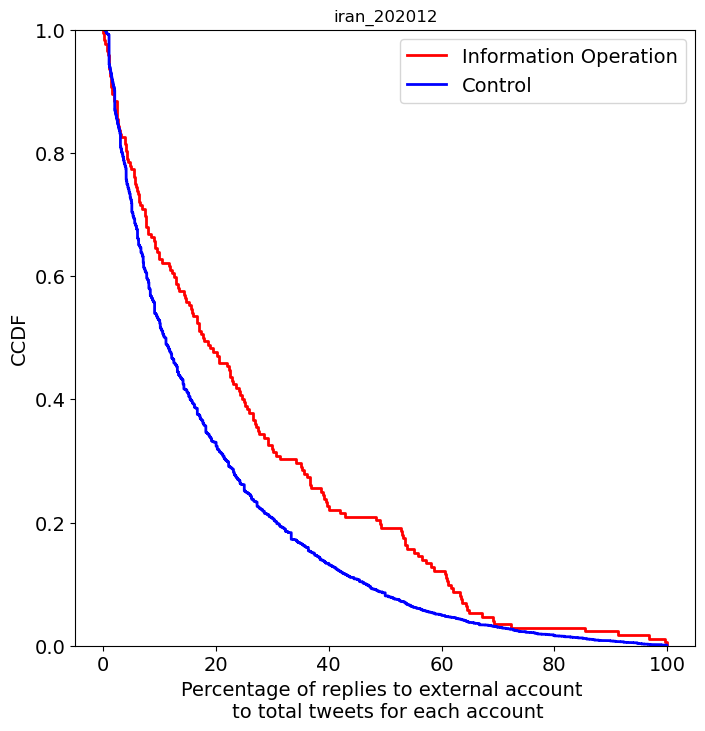

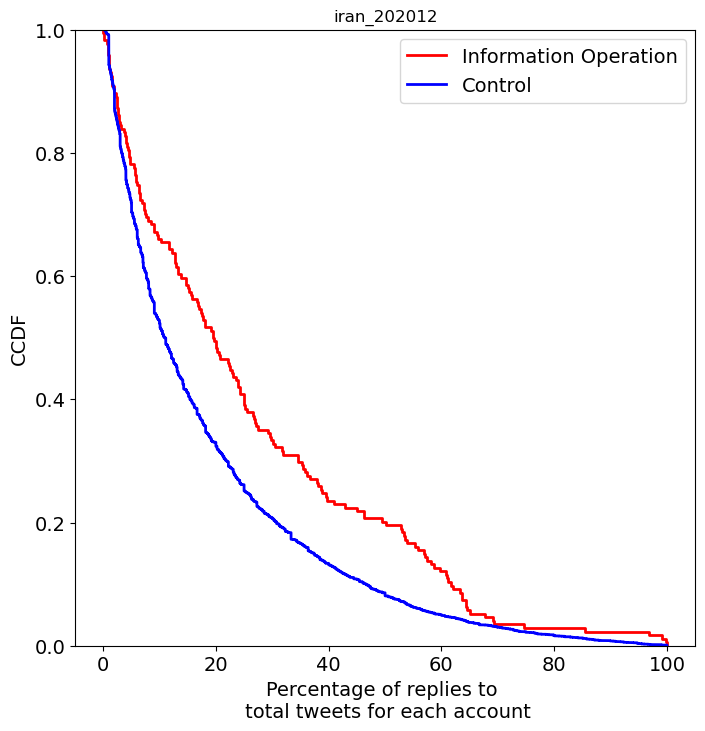

In [11]:
cdf_parameters = {
        'data': '',
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'per_replies',
                'label': 'Information Operation',
                'mean': False
            },
            {
                'column': 'per_replies',
                'label': 'Control',
                'mean': False
            },
        ],
        'x': 'Percentage of replies to external account \n to total tweets for each account',
        'complementary': True,
        'two_column': False,
        'xlabel': '',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        'random_color': False,
        # 'log_yscale': True,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_{iran_202012_campaign}_replies_outsider_to_tweet_percentage.png'
        }
    }

types = ['outsider', 'all']
names = ['Percentage of replies to external account \n to total tweets for each account',
         'Percentage of replies to \n total tweets for each account'
        ]
for i, reply in enumerate([replies, replies_all]):
    cdf_parameters['data'] = reply 
    reply_type = types[i]
    
    cdf_parameters['save']['filename'] = f'ccdf_{iran_202012_campaign}_replies_{reply_type}_to_tweet_percentage.png'
     
    cdf_parameters['xlabel'] = names[i]
    
    ccdf(cdf_parameters)

The replies to original tweet ratio for each account for Influence operation and control shows that the influence operation has the comparatively more ratio of replies. <br />
Possible explanation:
- Targeting external accounts for visiblity, harrashment

##### ***Comparing to other campaigns: Replying to outsider***


 ------ CNHU_0621 ------- 


 ------ CNCC_0621 ------- 


 ------ MX_0621 ------- 


 ------ REA_0621 ------- 


 ------ RNA_0621 ------- 


 ------ Tanzania_0621 ------- 


 ------ uganda_0621 ------- 


 ------ Venezuela_0621 ------- 


 ------ armenia_202012 ------- 


 ------ GRU_202012 ------- 


 ------ IRA_202012 ------- 


 ------ iran_202012 ------- 


 ------ ira_092020 ------- 


 ------ iran_092020 ------- 


 ------ thailand_092020 ------- 


 ------ cuba_082020 ------- 


 ------ qatar_082020 ------- 



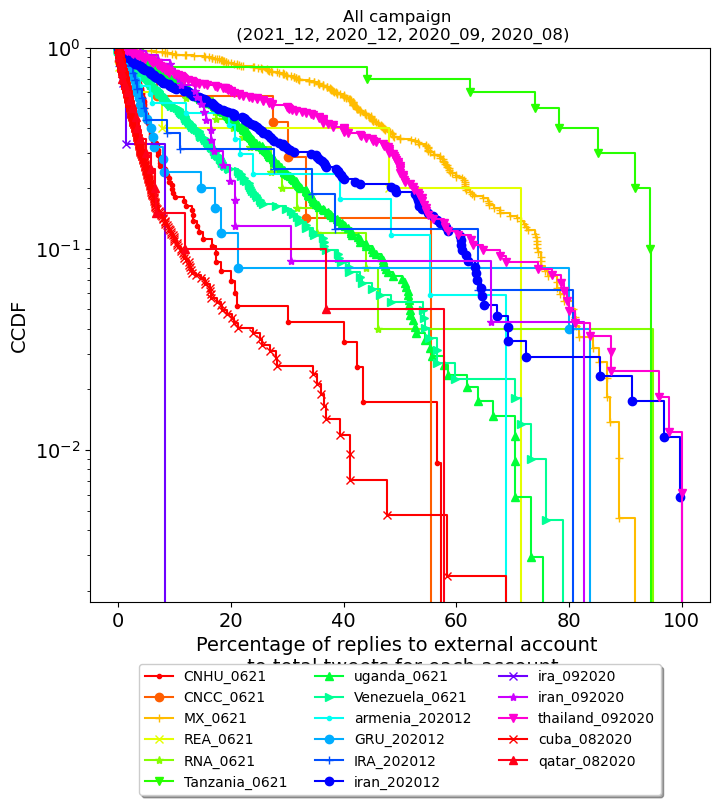

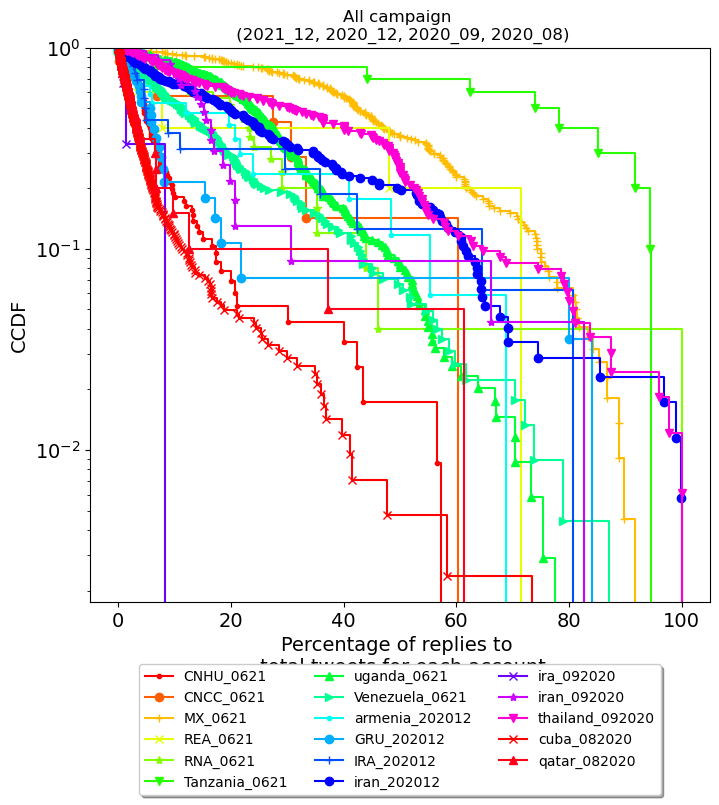

In [48]:
campaigns = {
    # '2021_12': ['Venezuela_0621', ],
    '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                'uganda_0621', 'Venezuela_0621'],
    '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 'iran_202012'],
    '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
    '2020_08': ['cuba_082020', 'qatar_082020'],
}

replies = []
replies_all = []
for year in campaigns:
    for new_campaign in campaigns[year]:
        print(f'\n ------ {new_campaign} ------- \n')
        
        ops_file_path = os.path.join(path, 'all_tweets', year, 
                               new_campaign, f'{new_campaign}_tweets.pkl.gz')
        control_file_path = None
        
        data_new = read_ops_control_data(ops_file_path, 
                                     control_file_path, 
                                     ['ops'])

        for type_of in ['ops']:
            df = data_new[type_of]
            df_new = filter_tweets(df, 10)

            df_replies = replies_to_tweet_ratio(df_new, 
                                                outsider=True)
            df_replies_total = replies_to_tweet_ratio(df_new, 
                                                outsider=False)

            replies.append(df_replies)
            replies_all.append(df_replies_total)


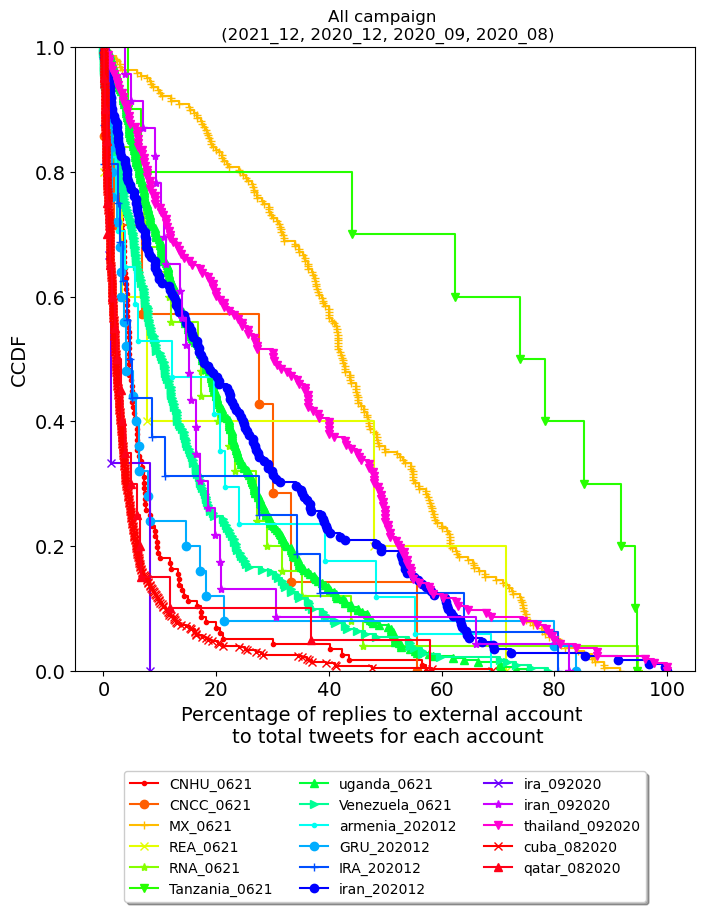

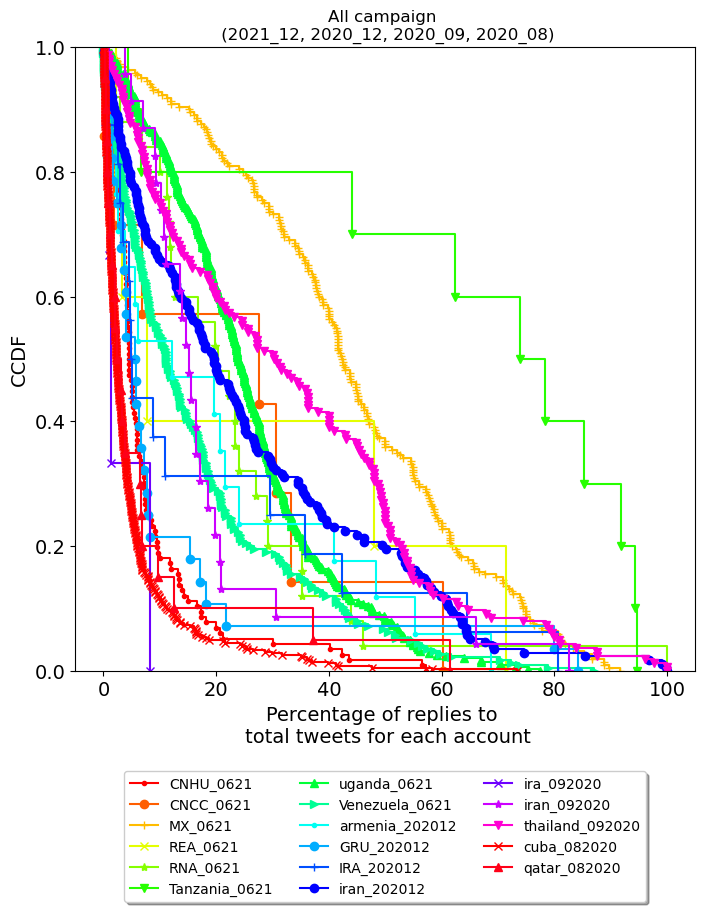

In [76]:
columns = []

for year in campaigns:
    for new_campaign in campaigns[year]:
        columns.append({
            'column': 'per_replies',
            'label': new_campaign,
            'mean': False
        })
        
multi_parameters = {
        'data': '',
        'size': (8, 9),
        'fontsize': 14,
        'title': 'All campaign \n (2021_12, 2020_12, 2020_09, 2020_08)',
        'sharex': True,
        'sharey': True,
        'columns': columns,
        'x': 'Count of users replying to tweets from external accounts',
        'complementary': True,
        'two_column': False,
        'xlabel': 'Count of users replying to tweets from external accounts',
        'ylabel': 'CCDF',
        # 'legend_location': 'upper right',
        'random_color': True,
        # 'log_yscale': True,
        'legend_lower': True,

        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_all_campaign_replying_user_count_outer.png'
        }
    }


types = ['outsider', 'all']
names = ['Percentage of replies to external account \n to total tweets for each account',
         'Percentage of replies to \n total tweets for each account'
        ]
for i, reply in enumerate([replies, replies_all]):
    multi_parameters['data'] = reply 
    reply_type = types[i]
    
    multi_parameters['save']['filename'] = f'ccdf_replies_{reply_type}_to_tweet_percentage.png'
     
    multi_parameters['xlabel'] = names[i]
    
    ccdf_symbol(multi_parameters)

In [10]:
def bundle_campaign(all_campaigns=None,
                    bundle=None
                   ):
    '''
    Splits the campaign data into parts according to bundle list
    
    :param all_campaigns: dictionary of campaigns
    :param bundle: list of keys to split
    
    :return splited dictionary, concated names of keys
    '''
    
    if all_campaigns == None:
        all_campaigns = {
            '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                        'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                        'uganda_0621', 'Venezuela_0621'],
            '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 
                        'iran_202012'],
            '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
            '2020_08': ['cuba_082020', 'qatar_082020'],

            '2020_05' : [
                         'china_052020', 
                         'turkey_052020',
                         'russia_052020' #incomplete control data
                        ],
            '2020_04' : ['egypt_022020', 'honduras_022020',
                         'indonesia_022020', 'sa_eg_ae_022020',
                         'serbia_022020'],
            '2020_03': ['ghana_nigeria_032020'],
            '2019_11': ['saudi_arabia_112019'],
            '2019_08': ['china_082019',
                        'ecuador_082019', 
                        'egypt_uae_082019', 
                        # 'saudi_arabia_082019', 
                        'spain_082019',
                        'uae_082019'],
            '2019_06': ['catalonia_201906_1',
                        # 'russia_201906_1', #need checking
                        # 'iran_201906_1',
                        # 'iran_201906_2',
                        # 'iran_201906_3',
                        'venezuela_201906_1'
                       ],
            '2019_01': ['iran_201901_1', 
                        'russia_201901_1',
                        'bangladesh_201901_1',
                        'venezuela_201901',
                       ],
            '2018_10': ['ira', 'iranian'],
        }


    if bundle == None:
        bundle = [
            # ['2021_12', '2020_12', '2020_09', '2020_08'], 
            ['2020_05', '2020_04', '2020_03', '2019_11'], 
            ['2019_08', '2019_06', '2019_01', '2018_10']
        ]
    
    names = []
    splits = []

    for row in bundle:
        split_bundle = {key: all_campaigns[key] for key in row}
        
        splits.append(split_bundle)
        names.append(','.join(row))
    
    return splits, names


 ------ china_052020 ------- 


 ------ turkey_052020 ------- 


 ------ russia_052020 ------- 


 ------ egypt_022020 ------- 


 ------ honduras_022020 ------- 


 ------ indonesia_022020 ------- 


 ------ sa_eg_ae_022020 ------- 


 ------ serbia_022020 ------- 


 ------ ghana_nigeria_032020 ------- 


 ------ saudi_arabia_112019 ------- 



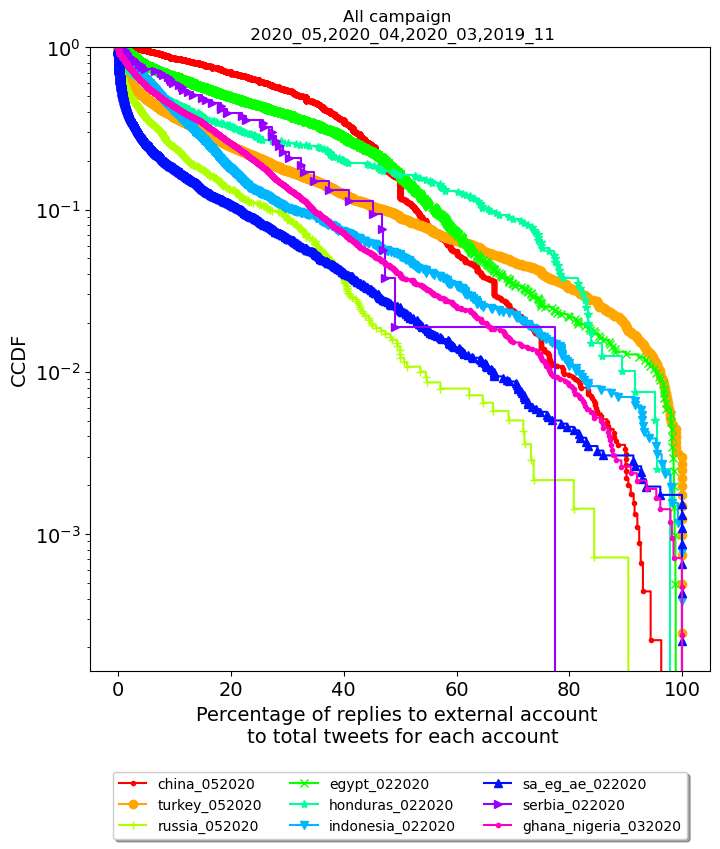

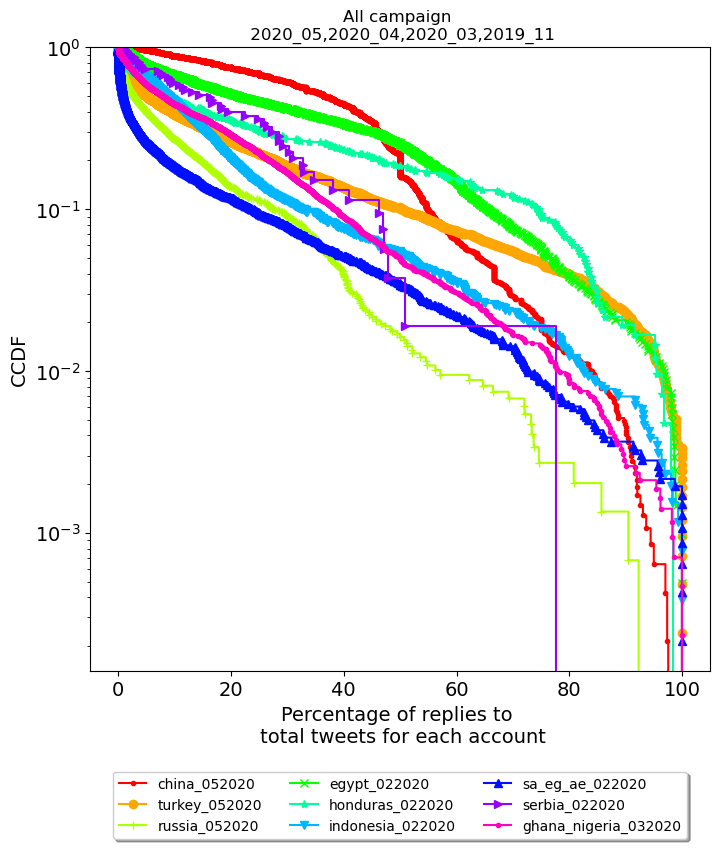


 ------ china_082019 ------- 


 ------ ecuador_082019 ------- 


 ------ egypt_uae_082019 ------- 


 ------ spain_082019 ------- 


 ------ uae_082019 ------- 


 ------ catalonia_201906_1 ------- 


 ------ venezuela_201906_1 ------- 


 ------ iran_201901_1 ------- 


 ------ russia_201901_1 ------- 


 ------ bangladesh_201901_1 ------- 


 ------ venezuela_201901 ------- 


 ------ ira ------- 


 ------ iranian ------- 



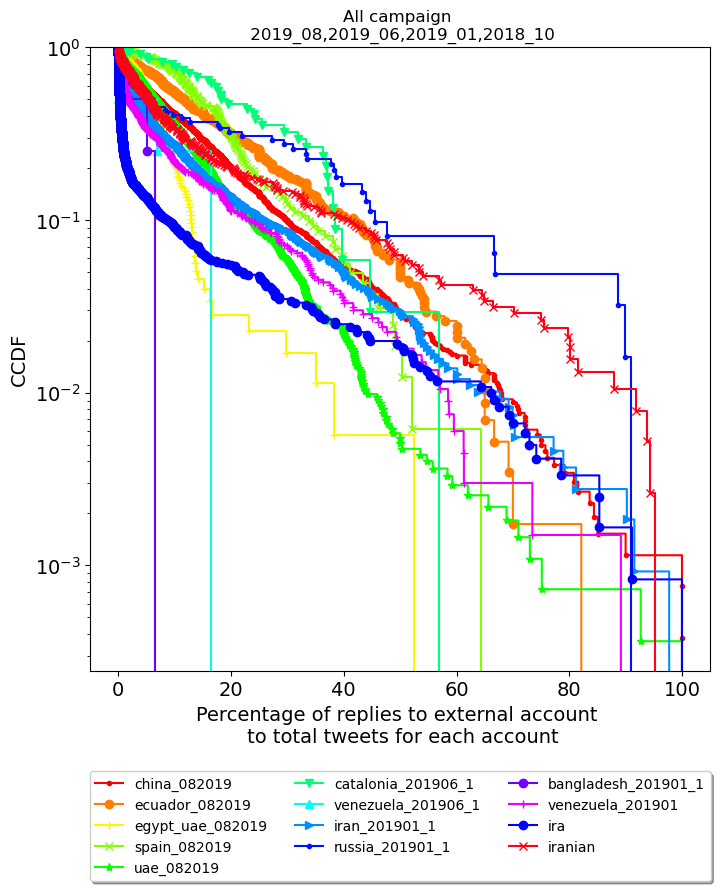

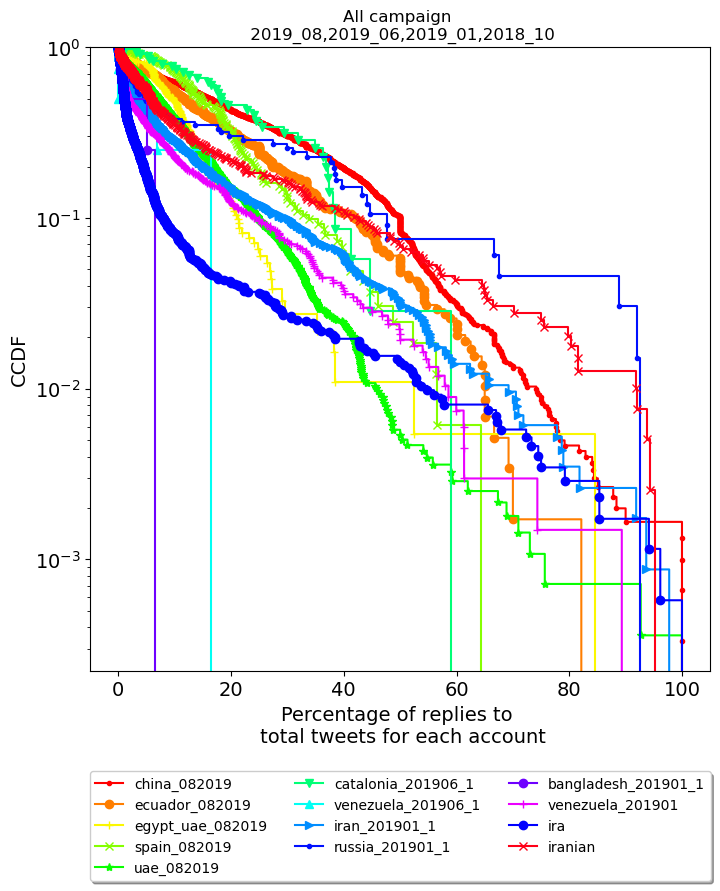

In [13]:
split_bundle, names = bundle_campaign()

for i, all_campaigns in enumerate(split_bundle):
    replies = []
    replies_all = []
    for year in all_campaigns:
        for new_campaign in all_campaigns[year]:
            print(f'\n ------ {new_campaign} ------- \n')

            ops_file_path = os.path.join(path, 'all_tweets', year, 
                                   new_campaign, f'{new_campaign}_tweets.pkl.gz')
            control_file_path = None

            data_new = read_ops_control_data(ops_file_path, 
                                         control_file_path, 
                                         ['ops'])

            for type_of in ['ops']:
                df = data_new[type_of]
                
                if 'in_reply_to_tweetid' not in df.columns:
                    continue
                    
                df_new = filter_tweets(df, 10)

                df_replies = replies_to_tweet_ratio(df_new, 
                                                    outsider=True)
                df_replies_total = replies_to_tweet_ratio(df_new, 
                                                    outsider=False)

                replies.append(df_replies)
                replies_all.append(df_replies_total)
    columns = []

    for year in all_campaigns:
        for new_campaign in all_campaigns[year]:
            columns.append({
                'column': 'per_replies',
                'label': new_campaign,
                'mean': False
            })
            
    name = names[i]
    
    
    multi_parameters = {
            'data': None,
            'size': (8, 9),
            'fontsize': 14,
            'title': f'All campaign \n {name}',
            'sharex': True,
            'sharey': True,
            'columns': columns,
            'x': 'Count of users replying to tweets from external accounts',
            'complementary': True,
            'two_column': False,
            'xlabel': 'Count of users replying to tweets from external accounts',
            'ylabel': 'CCDF',
            # 'legend_location': 'upper right',
            'random_color': True,
            'log_yscale': True,
            'legend_lower': True,

            # 'log_xscale': False,
            'save': {
                'path': f'{plot_path}',
                'filename': f'ccdf_{name}_campaign_replying_user_count_outer.png'
            }
        }


    types = ['outsider', 'all']
    xlabels = ['Percentage of replies to external account \n to total tweets for each account',
             'Percentage of replies to \n total tweets for each account'
            ]
    for i, reply in enumerate([replies, replies_all]):
        multi_parameters['data'] = reply 
        reply_type = types[i]

        multi_parameters['save']['filename'] = f'ccdf_replies_{name}_{reply_type}_to_tweet_percentage.png'

        multi_parameters['xlabel'] = xlabels[i]

        ccdf_symbol(multi_parameters)

#### **Per month reply activity**

In [14]:
replies_per_month = []
replies_outsider_per_month = []
for type_of in ['ops', 'control']:
    df = data[type_of]
    df_new = filter_tweets(df, 10)
    
    #per month activity
    df_time = add_tweet_time_month(df)
    min_date = min(df_time['tweet_time'])
    max_date = max(df_time['tweet_time'])

    df_date = get_date_range(min_date, max_date)
    df_with_date = add_date_range(df_time, df_date)

#     # print(df_with_date.info())
    df_per_month = per_month_activity(df_with_date, 
                                      columns=['tweet_time_month'],
                                      outsider=False
                                     )
    # df_per_month_outsider = per_month_activity(df_with_date, 
    #                                   columns=['tweet_time_month'],
    #                                   outsider=True
    #                                  )
    df_per_month = df_per_month.sort_values(by=['tweet_time_month'],
                            ascending=True
                           )
    # df_per_month_outsider = df_per_month_outsider.sort_values(
    #     by=['tweet_time_month'], 
    #     ascending=True)
    
    replies_per_month.append(df_per_month)
    # replies_outsider_per_month.append(df_per_month_outsider)

/N/u/potem/Quartz/miniconda3/lib/python3.9/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


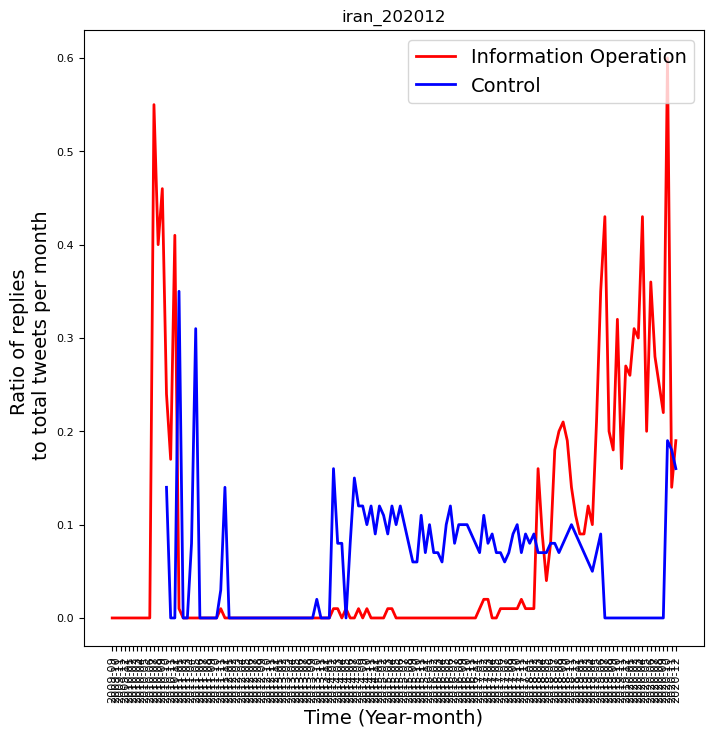

In [17]:
timeseries_parameters = {
        'data': replies_per_month,
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'x': 'tweet_time_month',
                'y': 'ratio_reply',
                'label': 'Information Operation',
            },
            {
                'x': 'tweet_time_month',
                'y': 'ratio_reply',
                'label': 'Control',
            },
        ],
        'x': 'Percentage of replies \n to total tweets per month',
        'two_column': False,
        'ylabel': 'Ratio of replies \n to total tweets per month',
        'xlabel': 'Time (Year-month)',
        'legend_location': 'upper right',
        'random_color': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'{iran_202012_campaign}_replies_to_tweet_percentage_timeseries.png'
        }
    }


single_plot(timeseries_parameters)

Above plot shows that the way control is collected is problematic as the control is based on hashtags

##### **Reply to outsider vs total reply activity**

In [27]:
replies = []
for type_of in ['ops']:
    df = data[type_of]
    
    #per month activity
    df_time = add_tweet_time_month(df)
    min_date = min(df_time['tweet_time'])
    max_date = max(df_time['tweet_time'])

    df_date = get_date_range(min_date, max_date)
    df_with_date = add_date_range(df_time, df_date)

#     # print(df_with_date.info())
    df_per_month = per_month_activity(df_with_date, 
                                      columns=['tweet_time_month'],
                                      outsider=False
                                     )
    df_per_month_outsider = per_month_activity(df_with_date, 
                                      columns=['tweet_time_month'],
                                      outsider=True
                                     )
    df_per_month = df_per_month.sort_values(by=['tweet_time_month'],
                            ascending=True
                           )
    df_per_month_outsider = df_per_month_outsider.sort_values(
        by=['tweet_time_month'], 
        ascending=True)
    
    print(max(df_per_month['ratio_reply']))
    print(max(df_per_month_outsider['ratio_reply']))
    
    replies.append(df_per_month)
    replies.append(df_per_month_outsider)

0.6
0.6


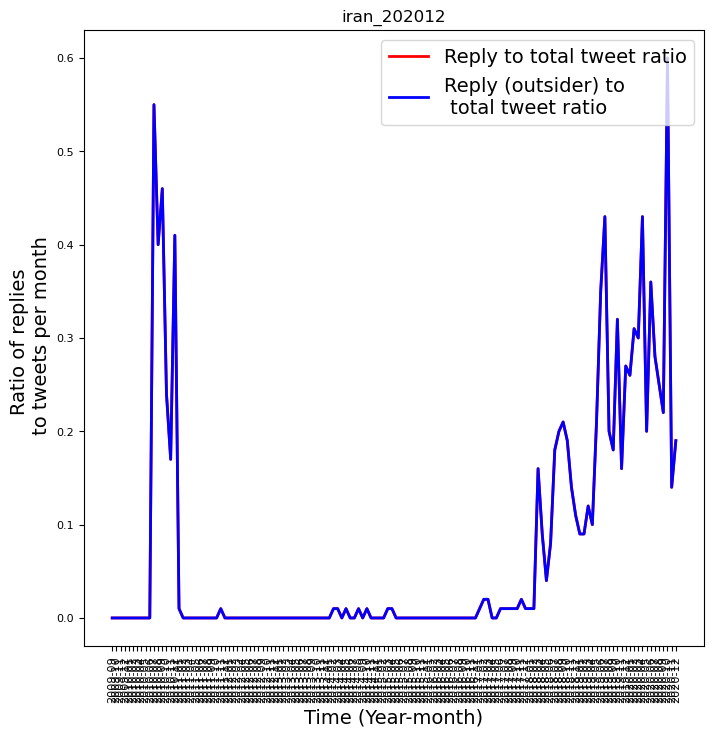

In [29]:
timeseries_parameters = {
        'data': replies,
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'x': 'tweet_time_month',
                'y': 'ratio_reply',
                'label': 'Reply to total tweet ratio',
            },
            {
                'x': 'tweet_time_month',
                'y': 'ratio_reply',
                'label': 'Reply (outsider) to \n total tweet ratio',
            },
        ],
        'x': 'Percentage of replies \n to total tweets per month',
        'two_column': False,
        'ylabel': 'Ratio of replies \n to tweets per month',
        'xlabel': 'Time (Year-month)',
        'legend_location': 'upper right',
        'random_color': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'{iran_202012_campaign}_replies_to_tweet_outsider_total_timeseries.png'
        }
    }


single_plot(timeseries_parameters)

Overlapping plot: There is no difference in reply to outsider and total reply activity. This shows that most of the replies are to outsider

##### **Comparing accross campaigns**

In [31]:
campaigns = {
    # '2021_12': ['Venezuela_0621', ],
    '2021_12': ['CNHU_0621', 'CNCC_0621', 'MX_0621', 
                'REA_0621', 'RNA_0621', 'Tanzania_0621', 
                'uganda_0621', 'Venezuela_0621'],
    '2020_12': ['armenia_202012', 'GRU_202012', 'IRA_202012', 'iran_202012'],
    '2020_09': ['ira_092020', 'iran_092020', 'thailand_092020'],
    '2020_08': ['cuba_082020', 'qatar_082020'],
}

replies = []
replies_outsider = []
for year in campaigns:
    for new_campaign in all_campaigns[year]:
        print(f'\n ------ {new_campaign} ------- \n')
        
        ops_file_path = os.path.join(path, 'all_tweets', year, 
                               new_campaign, f'{new_campaign}_tweets.pkl.gz')
        control_file_path = None
        
        data_new = read_ops_control_data(ops_file_path, 
                                     control_file_path, 
                                     ['ops'])

        for type_of in ['ops']:
            df = data_new[type_of]

            #per month activity
            df_time = add_tweet_time_month(df)
            min_date = min(df_time['tweet_time'])
            max_date = max(df_time['tweet_time'])

            df_date = get_date_range(min_date, max_date)
            df_with_date = add_date_range(df_time, df_date)

        #     # print(df_with_date.info())
            df_per_month = per_month_activity(df_with_date, 
                                              columns=['tweet_time_month'],
                                              outsider=False
                                             )
            df_per_month_outsider = per_month_activity(df_with_date, 
                                              columns=['tweet_time_month'],
                                              outsider=True
                                             )
            df_per_month = df_per_month.sort_values(by=['tweet_time_month'],
                                    ascending=True
                                   )
            df_per_month_outsider = df_per_month_outsider.sort_values(
                by=['tweet_time_month'], 
                ascending=True)

            print(max(df_per_month['ratio_reply']))
            print(max(df_per_month_outsider['ratio_reply']))
            
            df_per_month['counter'] = range(len(df_per_month))
            df_per_month_outsider['counter'] = range(len(df_per_month_outsider))

            replies.append(df_per_month)
            replies_outsider.append(df_per_month_outsider)


 ------ CNHU_0621 ------- 

0.42
0.42

 ------ CNCC_0621 ------- 

1.0
1.0

 ------ MX_0621 ------- 

0.46
0.46

 ------ REA_0621 ------- 

1.0
1.0

 ------ RNA_0621 ------- 

1.0
1.0

 ------ Tanzania_0621 ------- 

1.0
1.0

 ------ uganda_0621 ------- 

1.0
1.0

 ------ Venezuela_0621 ------- 

1.0
1.0

 ------ armenia_202012 ------- 

0.5
0.5

 ------ GRU_202012 ------- 

0.69
0.69

 ------ IRA_202012 ------- 

0.59
0.59

 ------ iran_202012 ------- 

0.6
0.6

 ------ ira_092020 ------- 

0.4
0.4

 ------ iran_092020 ------- 

0.53
0.53

 ------ thailand_092020 ------- 

0.88
0.88

 ------ cuba_082020 ------- 

0.44
0.44

 ------ qatar_082020 ------- 

0.15
0.15


In [41]:
def multiple_time_series(parameters):
    '''
    Plots the time series of multiple data
    :param parameters: parameters for visualization
    '''
    
    if 'size' in parameters:
        size = parameters['size']
    else:
        size = (10, 10)
        
    fig, ax = plt.subplots(figsize=size)
        
    fontsize = 14
    colors = ['red', 'blue', 'orange', 'red', 'olive', 
              'pink', 'lime', 'maroon']
    x_index = np.arange(len(data))
    
    x_label = parameters['xlabel']
    y_label = parameters['ylabel']
    title = parameters['title']
    plot_path = parameters['save']['path']
    filename = parameters['save']['filename']
    
    total_columns = len(parameters['columns'])
    all_colors =  [k for k,v in pltc.cnames.items()]
    colors = get_cmap(total_columns)
    symbols = ['.', 'o', '+', 'x', '*', 'v', '^', '>']
    marker = itertools.cycle(symbols) 
    colors = ['red', 'blue', 'green', 'orange', 'olive', 'pink', 'lime', 'maroon']

    for index, df in enumerate(parameters['data']):
        x = parameters['columns'][index]['x']
        y = parameters['columns'][index]['y']
        label = parameters['columns'][index]['label']
        
        ax.plot(df[x], 
                df[y],
                color=colors[index],
                marker=next(marker),
                label=label,
                linewidth=2,
               )
        
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.tick_params(axis='both', which='both', 
                       labelsize=8, labelbottom=True)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

    ax.legend(loc="upper right", 
              frameon=True, 
              fontsize=fontsize)
    ax.set_title(f'{title}')
    ax.tick_params(axis='x', labelrotation=90)
    
    plt.xticks(rotation = 90)
    plt.title(title)
        
    plt.show()
    
    fig.savefig(f'{plot_path}/{filename}.png', 
          facecolor='white', 
          transparent=False)
    

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

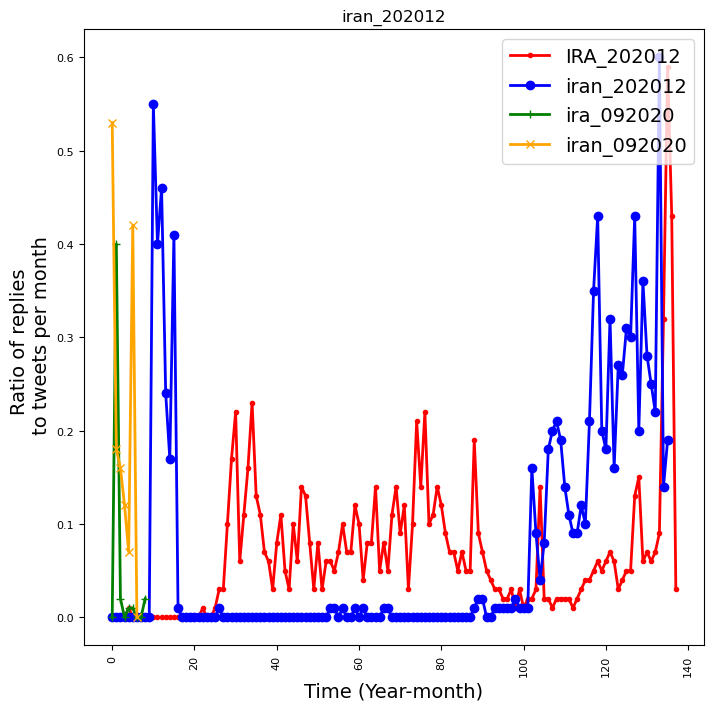

In [45]:
columns = []
for year in campaigns:
    for new_campaign in campaigns[year]:
        columns.append({
            'x': 'counter',
            'label': new_campaign,
            'y': 'ratio_reply'
        })
            

timeseries_parameters = {
        'data': replies[10:14],
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': columns[10:14],
        'x': 'Percentage of replies \n to total tweets per month',
        'two_column': False,
        'ylabel': 'Ratio of replies \n to tweets per month',
        'xlabel': 'Time (Year-month)',
        'legend_location': 'upper right',
        'random_color': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'all_replies_to_tweet_timeseries.png'
        }
    }


multiple_time_series(timeseries_parameters)

In [ ]:
##############################################

In [ ]:
def mention_percentage_per_user(df, only_reply=False):
    '''
    Gets the ratio of mentioned account to total activity for each account
    
    :param df: dataframe
    :param only_reply: boolen to specify whether to include the only replies
    
    :return dataframe
    '''
    new_data = []
    #filter out the users with less than 10 tweets (replies, retweet, quote or original tweet)
    # df = filter_tweets(df, is_retweet=False, only_replies=only_replies, threshold=100)

    #Extracts all the mentions
    df = df.fillna(0)
    df = filter_tweets(df)
    df = df.loc[(df['is_retweet'] == False)]
    
    #Total activity
    df_total = (df.loc[df['is_retweet'] == False]
                .groupby(['userid'])['tweetid']
                .size()
                .to_frame('total_count')
                .reset_index())
    
    if only_reply == True:
        print('here')
        df = df.loc[~(df['in_reply_to_userid'].isnull())]

    #total mentioned to specific account by specific userid
    df_mentions = extract_mentions(df, filter_tweet=True, 
                          explode=True)

    df_grps = (df_mentions
               .groupby(['mentions_from_text', 'userid'])['tweetid']
               .size()
               .to_frame('mention_count')
               .reset_index()
              )
        
    #filter out total tweets with mentions < 50
    # df_total = df_total.loc[df_total['total_count'] > 100]

    df_grps = df_grps.merge(df_total, on='userid',
                            how='inner')

    df_grps['mention_by_total'] = round(df_grps['mention_count']/df_grps['total_count'], 2)

    df_grps = df_grps.sort_values(by=['mention_by_total'],
                    ascending=False
                   )
        
    return df_grps


def mentioned_tweet_user_count(df_ops, is_retweet=False, is_reply=False):
    '''
    Gets the ratio of tweets received by mentioned account, number of users involved
    
    :param df_ops: dataframe
    :param is_retweet: boolean to include retweet or not
    :param is_reply: boolean to include just replies
    
    :return dataframe
    '''
    total = len(df_ops)
    df_ops = filter_tweets(df_ops)
    
    df_ops = df_ops.loc[df_ops['is_retweet'] == is_retweet]
        
    if is_reply == True:
        df_ops = df_ops.loc[~df_ops['in_reply_to_userid'].isnull()]

    df_mentions_ind = extract_mentions(df_ops, filter_tweet=True, 
                              explode=True)

    df_total_received_tweet = (df_mentions_ind
                   .groupby(['mentions_from_text'])['tweetid']
                   .size()
                   .to_frame('tweet_count')
                   .reset_index()
                  )
    df_mention_grp = (df_mentions_ind
                   .groupby(['mentions_from_text'])['userid']
                   .nunique()
                   .to_frame('user_count')
                   .reset_index()
                  )
    df_total_received_tweet = df_total_received_tweet.merge(df_mention_grp, 
                                  on=['mentions_from_text'],
                                 )

    df_total_received_tweet['per_tweet'] = df_total_received_tweet['tweet_count'] / total
    
    df_total_received_tweet = df_total_received_tweet.sort_values(by=['tweet_count'], 
                                                                  ascending=False)
    
    return df_total_received_tweet


In [ ]:
#checking ratios

df_grps = mention_percentage_per_user(df_ops)

df_grps.sort_values(by=['mention_by_total'],
                    ascending=False
                   )

In [ ]:
#Checking how many people are involved

df_total_received_tweet = mentioned_tweet_user_count(df_ops, False, False)

df_total_received_tweet.sort_values(by=['user_count'],
                    ascending=False
                   ).head(5)

In [ ]:
top_mentions = df_total_received_tweet.sort_values(by=['user_count'],
                                    ascending=False
                                   )['mentions_from_text'].head(10)

Checking top 10 mentions and tweets

In [ ]:
df_top_mentions = extract_mentions(df_ops, 
                               filter_tweet=True, 
                               explode=True)

df_tweet_text = (df_top_mentions
                 .loc[df_top_mentions['mentions_from_text']
                      .isin(top_mentions)][['tweet_text', 'userid', 
                                            'user_display_name', 'tweetid', 
                                            'mentions_from_text', 'in_reply_to_userid']])

df_tweet_text.to_csv('test_tweet_text_all_top_10.csv')


pd.options.display.max_colwidth = 150 

df_tweet_text

In [ ]:
### Reply coordination

In [ ]:
df_grps_reply = mention_percentage_per_user(df_ops, only_reply=True)

df_grps_reply.sort_values(by=['mention_by_total'],
                    ascending=False
                   )

In [ ]:
df_total_reply = mentioned_tweet_user_count(df_ops, False, True)

df_total_reply.sort_values(by=['user_count'],
                    ascending=False
                   ).head(5)

In [ ]:
#top 10 replied

top_mentions = df_total_reply.sort_values(by=['user_count'],
                                    ascending=False
                                   )['mentions_from_text'].head(10)

df_top_mentions = extract_mentions(df_ops, 
                               filter_tweet=True, 
                               explode=True)
df_top_mentions = df_top_mentions.loc[~df_top_mentions['in_reply_to_userid'].isnull()]

tweet_ids = (df_top_mentions
                 .loc[df_top_mentions['mentions_from_text']
                      .isin(top_mentions)]['tweetid'].unique())
             
df_tweet_text = df_ops.loc[df_ops['tweetid'].isin(tweet_ids)][[
    'tweet_text', 'userid', 
    'user_display_name', 'tweetid', 
    'mentions_from_text', 'in_reply_to_userid', 
    'in_reply_to_tweetid']]

df_tweet_text = df_tweet_text.sort_values(by=['in_reply_to_tweetid'])

df_tweet_text.to_csv('test_tweet_text_replies_top_10.csv')


pd.options.display.max_colwidth = 150 

df_tweet_text

In [ ]:
### Testing on average how many users 

In [ ]:
#number of unique users replying to 

# df_tweet_grp = (df_tweet_text
#                 .groupby(['in_reply_to_tweetid'])['userid']
#                 .nunique()
#                 .to_frame('count')
#                 .reset_index()
#                )

# df_tweet_grp

# for name, group in df_tweet_grp:
#     # print(name)
#     print('---------')
#     print(group[['tweet_text', 'userid', 'in_reply_to_tweetid']])
#     # break

flag = ~(df_ops['in_reply_to_userid'].isnull())
flag_2 = df_ops['in_reply_to_userid'].isin(df_ops['userid'])

df_replies = df_ops.loc[flag & flag_2]

df_reply_grp = (df_replies.groupby(['in_reply_to_tweetid'])['userid']
                # .nunique()
                .size()
                .to_frame('count')
                .reset_index()
               )

print('Max number of accounts replying to tweet ', max(df_reply_grp['count']))

pd.options.display.max_colwidth = 150 


df_reply_grp

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

df_reply_grp['in_reply_to_tweetid']

In [ ]:
df_tweet_grp['count'].max()

## Positive example: iran_202012
### Test if replies data is there

In [ ]:
#thailand_092020

iran_202012_campaign = 'iran_202012'
year = '2020_12'
        
ops_file_path = os.path.join(path, 'all_tweets', year, 
                       iran_202012_campaign, f'{iran_202012_campaign}_tweets.pkl.gz')
control_file_path = os.path.join(path, 'all_tweets', year, 
                            iran_202012_campaign, 'DriversControl', 
                            f'{iran_202012_campaign}_control.pkl.gz')

data = read_ops_control_data(ops_file_path, control_file_path)
print(data['control'].info())

In [ ]:
df_control = data['ops']

In [ ]:
# df_control = df_control.astype({
#     'in_reply_to_userid': int
# })

df_control = df_control.fillna(0)
    
df_control = df_control.astype({
    'in_reply_to_userid': int,
    'in_reply_to_tweetid': int
})

In [ ]:
len(df_control.loc[~(df_control['in_reply_to_tweetid'] == 0)])

In [ ]:
type(df_control['in_reply_to_tweetid'].unique()[0])

In [ ]:
df = add_tweet_time_month(df_control)

min_date = min(df['tweet_time'])
max_date = max(df['tweet_time'])

df_date = get_date_range(min_date, max_date)

df_with_date = add_date_range(df, df_date)

# print(df_with_date.info())
df_per_month = per_month_activity(df_with_date, columns=['tweet_time_month'])
df_per_month = df_per_month.sort_values(by=['tweet_time_month'],
                        ascending=True
                       )
print(df_per_month.head())
# print(df['tweet_time_month'].head())

In [ ]:
def single_plot(parameters):
    if 'size' in parameters:
        size = parameters['size']
    else:
        size = (10, 10)
        
    fig, ax = plt.subplots(figsize=size)
        
    fontsize = 14
    colors = ['red', 'blue', 'orange', 'red', 'olive', 
              'pink', 'lime', 'maroon']
    x_index = np.arange(len(data))
    
    
    x_label = parameters['xlabel']
    y_label = parameters['ylabel']
    title = parameters['title']
    plot_path = parameters['save']['path']
    filename = parameters['save']['filename']
    
    for index, df in enumerate(parameters['data']):
        x = parameters['columns'][index]['x']
        y = parameters['columns'][index]['y']
        label = parameters['columns'][index]['label']
        
        ax.plot(df[x], 
                df[y],
                color=colors[index],
                label=label,
                linewidth=2,
               )
        
       
        # ax.axhline(round(data[key].mean(), 2),
        #            color=colors[i],
        #            linewidth=2
        #           )
        # ax.axhline(round(data[key].median(), 2),
        #            color=colors[i],
        #            marker='+',
        #            linewidth=5
        #           )
        
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.set_xlabel(x_label, fontsize=fontsize)
        
        # new_axis.set_xticks(x_index, data[x])
        # new_axis.set_xlabel('Time (Year-month)', 
        # fontsize=fontsize)
        
    ax.tick_params(axis='both', which='both', 
                       labelsize=8, labelbottom=True)
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelbottom=True)

    ax.legend(loc="upper right", 
              frameon=True, 
              fontsize=fontsize)
    ax.set_title(f'{title}')
    ax.tick_params(axis='x', labelrotation=90)
    
    plt.xticks(rotation = 90)
    plt.title(title)
        
    plt.show()
    
    fig.savefig(f'{plot_path}/{filename}.png', 
          facecolor='white', 
          transparent=False)
    



In [ ]:
replies = []
replies_per_month = []
for type_of in ['ops', 'control']:
    df = data[type_of]
    df_new = filter_tweets(df)
    df_replies = replies_to_tweet_ratio(df_new)

    replies.append(df_replies)
    
    #per month activity
    df_time = add_tweet_time_month(df)
    min_date = min(df_time['tweet_time'])
    max_date = max(df_time['tweet_time'])

    df_date = get_date_range(min_date, max_date)

    df_with_date = add_date_range(df_time, df_date)

    # print(df_with_date.info())
    df_per_month = per_month_activity(df_with_date, columns=['tweet_time_month'])
    df_per_month = df_per_month.sort_values(by=['tweet_time_month'],
                            ascending=True
                           )
    replies_per_month.append(df_per_month)
        
        
cdf_parameters = {
        'data': replies,
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'per_replies',
                'label': 'Information Operation',
                'mean': False
            },
            {
                'column': 'per_replies',
                'label': 'Control',
                'mean': False
            },
        ],
        'x': 'Percentage of replies to external account \n to total tweets for each account',
        'complementary': True,
        'two_column': False,
        'xlabel': 'Percentage of replies to external account \n to total tweets for each account',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
        'random_color': False,
        'log_yscale': True,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'ccdf_{iran_202012_campaign}_replies_to_tweet_percentage.png'
        }
    }

ccdf(cdf_parameters)

In [ ]:
timeseries_parameters = {
        'data': replies_per_month,
        'size': (8, 8),
        'fontsize': 14,
        'title': iran_202012_campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'x': 'tweet_time_month',
                'y': 'ratio_reply',
                'label': 'Information Operation',
            },
            {
                'x': 'tweet_time_month',
                'y': 'ratio_reply',
                'label': 'Control',
            },
        ],
        'x': 'Percentage of replies to external account \n to total tweets per month',
        'two_column': False,
        'ylabel': 'Ratio of replies to external account \n to total tweets per month',
        'xlabel': 'Time (Year-month)',
        'legend_location': 'upper right',
        'random_color': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'{iran_202012_campaign}_replies_to_tweet_percentage_timeseries.png'
        }
    }


single_plot(timeseries_parameters)

In [ ]:
#######################################################################

In [ ]:
def mention_percentage(df):
    new_data = []
    #filter out the users with less than 10 tweets (replies, retweet, quote or original tweet)
    # df = filter_tweets(df, is_retweet=False, only_replies=only_replies, threshold=100)

    #Extracts all the mentions
    df = df.fillna(0)

    df_new = df.loc[(df['is_retweet'] == False) & (df['in_reply_to_userid'] == 0)]
    df_mentions = convert_string_mention_to_list(df_new)
    df = extract_mentions(df, filter_tweet=True, 
                          explode=True)

    df_grps = (df
               .groupby(['mentions_from_text', 'userid'])['tweetid']
               .size()
               .to_frame('count')
               .reset_index()
              )

        #Total mentioning in tweet and replies (removing the retweet)
        df_total = (df.loc[df['is_retweet'] == False]
                    .groupby(['userid'])['tweetid']
                    .size()
                    .to_frame('total_count')
                    .reset_index())
        
        #filter out total tweets with mentions < 50
        df_total = df_total.loc[df_total['total_count'] > 100]

        df_grps = df_grps.merge(df_total, on='userid',
                                how='inner')

        df_grps['count_by_total_count'] = round(df_grps['count']/df_grps['total_count'] * 100)
        
        new_data.append(df_grps)
        
    return new_data

new_data = mention_percentage([data['ops'], data['control']])

### Per user mentioning

In [ ]:
len(new_data)

In [ ]:
df_control = new_data[1]

In [ ]:
df_control.sort_values(by=['count_by_total_count'], 
                       ascending=False).head(10)

In [ ]:
df_ops = new_data[0]

# df_ops['count_by_total_count'] = df_ops['count_by_total_count'].apply(
#     lambda x: round(x))

df_ops.sort_values(by=['count_by_total_count'],
                   ascending=False).head(10)

In [ ]:
df_ops.loc[df_ops['count_by_total_count'] > 60]['mentions_from_text'].unique()

Testing the percentage of zero in data

In [ ]:
zero_per = len(df_ops.loc[df_ops['count_by_total_count'] == 0])/len(df_ops)

print('percentage of zero in IO :', zero_per*100)

zero_control = len(df_control.loc[df_control['count_by_total_count'] == 0])/len(df_control)

print('percentage of zero in Control :', zero_control*100)

In [ ]:
min(df_control['count_by_total_count'])

Fitting ZIP model for IO

In [ ]:
df_group = 

In [ ]:
import statsmodels.api as sm

zip_training_results = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, 
                       exog_infl=X_train, inflation='logit').fit()


print(zip_training_results.summary())

In [ ]:
# df_ops = df_ops.loc[df_ops['count_by_total_count'] > 0]

df_ops['log10'] = np.log10(df_ops['count_by_total_count'] + 0.001)

The chi-square test is an alternative to the Anderson-Darling and Kolmogorov-Smirnov goodness-of-fit tests. The chi-square goodness-of-fit test can be applied to discrete distributions such as the binomial and the Poisson. The Kolmogorov-Smirnov and Anderson-Darling tests are restricted to continuous distributions.

## Normality test

In [ ]:
import statsmodels.api as sm

fig = sm.qqplot(df_ops['count_by_total_count'], line='45')

plt.show()

fig = sm.qqplot(df_ops['log10'], line='45')

plt.show()

In [ ]:
from scipy.stats import kstest

print(kstest(df_ops['count_by_total_count'], 'norm'))

print(kstest(df_ops['log10'], 'norm'))

#Since p value is less than 0.0, we reject the null hypothesis

In [ ]:
#Distribution of percentage
fig, ax = plt.subplots(figsize=(6, 6))
fontsize = 14

df_ops['log10'] = np.log10(df_ops['count_by_total_count'])
sns.kdeplot(data=df_ops['count_by_total_count'], ax=ax)

ax.set_xlabel('Percentage of mentioned tweets \n per user', 
              fontsize=fontsize)
ax.set_ylabel('Density', 
              fontsize=fontsize)

ax.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
fontsize = 14
sns.kdeplot(data=df_ops['log10'], ax=ax)

ax.set_xlabel('Percentage of mentioned tweets \n per user', 
              fontsize=fontsize)
ax.set_ylabel('Density', 
              fontsize=fontsize)

ax.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [ ]:
plt.hist(df_ops['count_by_total_count'], density=True, bins=100)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [ ]:
df_no_zero = df_ops.loc[df_ops['log10'] > 0]

plt.hist(df_no_zero['log10'], density=True, bins=100)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data')

In [ ]:
from scipy.stats import poisson

#Null hypothesis two distribution are same, 
#if <0.5 reject null hypothesis
mean_data = df_ops['count_by_total_count'].mean()
total = len(df_ops)
ks_statistic, p_value = kstest(df_ops['count_by_total_count'], 
                               'poisson', 
                               args=(mean_data,0),
                              N=total)
print(ks_statistic, p_value)


print(min(df_ops['log10']))
mean_data = df_no_zero['log10'].mean()
total = len(df_no_zero)
std = df_no_zero['log10'].std()
ks_statistic, p_value = kstest(df_no_zero['log10'], 
                               'poisson', 
                               args=(mean_data, std),
                              N=total)
print(ks_statistic, p_value)

In [ ]:
# from fitter import get_distributions
# # print(get_distributions())
# from fitter import get_common_distributions
# # get_common_distributions()


# f = Fitter(df_ops['count_by_total_count'],
#            distributions=['gamma',
#                           'lognorm',
#                           "beta",
#                           "burr",
#                           "norm",
#                           # ""
#                          ]
#           )

# f.fit()

# f.summary()

In [ ]:
def boxplot(parameters):
    if 'size' in parameters:
        size = parameters['size']
    else:
        size=(8,8)
        
    keys = parameters.keys()
    fig, ax = plt.subplots(figsize=size)
    fontsize = parameters['fontsize']
    data = parameters['data']
    i = 0
    columns = []
    ticks = []
    labels = []
    
    for df in data:
        column = parameters['columns'][i]['column']
        label = parameters['columns'][i]['label']
        
        columns.append(df[column])
        labels.append(label)
        
        i = i + 1
        ticks.append(i)
        
    ax.boxplot(columns)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

    ax.set_xlabel(parameters['xlabel'], 
                  fontsize=fontsize)
    ax.set_ylabel(parameters['ylabel'], 
                  fontsize=fontsize)
    
    plt.xticks(ticks, labels)
    
    if 'save' in keys:
        path = parameters['save']['path']
        filename = parameters['save']['filename']
        
        fig.savefig(f'{path}/{filename}', 
              facecolor='white', 
              transparent=False)
        
    plt.show()
    

In [ ]:
box_parameters = {
        'data': [df_ops, df_control],
        'size': (8, 8),
        'fontsize': 14,
        'title': campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'count_by_total_count',
                'label': 'Information Operation',
                'mean': False
            },
            {
                'column': 'count_by_total_count',
                'label': 'Control',
                'mean': False
            },
        ],
        'x': 'mentions_from_text',
        'two_column': False,
        'xlabel': '',
        'ylabel': 'Percentage of (mentions tweets)/ (total tweets)',
        'legend_location': 'upper right',
    
        # 'log_yscale': False,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'box_{campaign}_mentions_per_tweets_ops_control.png'
        }
    }


boxplot(box_parameters)

##################################################################################################################

### Per account mentioning

In [ ]:
df_raw_ops = (df_ops.sort_values(by=['count'], ascending=False)
             .groupby(['mentions_from_text'])['count', 'total_count']
             .sum()
             # .to_frame('sum')
             .reset_index()
             .sort_values(by=['count'], ascending=False)
             .query('total_count > 100')
            )

df_raw_ops['percentage'] = df_raw_ops['count'] /df_raw_ops['total_count'] * 100


print('\n ----------- Influence Operation ----------- \n')
print(df_raw_ops.sort_values(by=['percentage'], 
                             ascending=False).head(20))


df_raw_control = (df_control.sort_values(by=['count'], ascending=False)
             .groupby(['mentions_from_text'])['count', 'total_count']
             .sum()
             # .to_frame('sum')
             .reset_index()
             .sort_values(by=['count'], ascending=False)
             .query('total_count > 100')
            )

#Reason for using percentage, more user more tweets
df_raw_control['percentage'] = df_raw_control['count'] /df_raw_control['total_count'] * 100
      
print('\n ----------- Control ----------- \n')

print(df_raw_control.sort_values(by=['percentage'], 
                                 ascending=False).head(20))

### Checking overlapped accounts only for raw count

In [ ]:
df_all = df_raw_control.merge(df_raw_ops, 
                     how='inner',
                     on='mentions_from_text', 
                     suffixes=('_control', '_ops'))

df_all.sort_values(by=['percentage_ops'], ascending=False).head()

In [ ]:
df_all.info()

In [ ]:
df_all.info()

In [ ]:
bar_parameters = {
        'data': df_all.loc[df_all['percentage_control'] < df_all['percentage_ops']],
        'size': (18, 10),
        'fontsize': 14,
        'title': campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'percentage_ops',
                'label': 'Information Operation',
                'mean': False
            },
            {
                'column': 'percentage_control',
                'label': 'Control',
                'mean': False
            },
        ],
        'x': 'mentions_from_text',
        'two_column': False,
        'xlabel': 'Accounts',
        'ylabel': 'Percentage of (mentions tweets)/ (total tweets)',
        'legend_location': 'upper right',
    
        # 'log_yscale': False,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': f'bar_{campaign}_mentions_per_tweets_ops_control.png'
        }
    }

bar_single_plot(bar_parameters)

In [ ]:
df_all.head()

In [ ]:
# df_all.loc[df_all['percentage_control'] < df_all['percentage_ops']]

### Testing for all tweets and replies

In [ ]:
def ccdf(parameters):
    '''
    Plots ccdf for data
    
    :param parameters: parameters to set for the plot
    '''
    
    # {
    #     'data': df,
    #     'fontsize': 14,
    #     'complementary': True,
    #     'columns': [
    #         {'column': ''
    #          'label': '',
    #         },{
    #         'column': '',
    #          'label': ''
    #         }
    #     ],
    #     'xlabel': '',
    #     'ylabel': '',
    #     'legend_location': '',
    #     'log_yscale': True,
    #     'log_xscale': True,
    #     'save': {
    #         'path': '',
    #         'filename': ''
    #     }
    # }
    
    keys = parameters.keys()
    fig, ax = plt.subplots(figsize=(8, 8))
    fontsize = parameters['fontsize']
    colors = ['red', 'blue', 'green', 'orange', 'olive', 'pink', 'lime', 'maroon']
    
    # all_colors =  [k for k,v in pltc.cnames.items()]
    # colors = sample(all_colors, total_columns)
    
    symbols = ['.', 'o', '+', 'x', '*', 'v', '^', '>']
    
    i = 0
    total_columns = len(parameters['columns'])
    cmap = plt.cm.get_cmap('hsv', total_columns)
    
    for data in parameters['data']:
        if len(parameters['columns']) == 1:
            column = parameters['columns'][0]['column']
            label = parameters['columns'][0]['label']
        else:
            column = parameters['columns'][i]['column']
            label = parameters['columns'][i]['label']
            
        data = parameters['data'][i][column]
            
        sns.ecdfplot(data, 
                     complementary=parameters['complementary'],
                     label=label,
                     # marker=symbols[i],
                     color=colors[i],
                     ax=ax,
                     linewidth=2,)

        i = i + 1
        
    ax.set_xlabel(parameters['xlabel'], 
                  fontsize=fontsize)
    ax.set_ylabel(parameters['ylabel'], 
                  fontsize=fontsize)

    ax.set_ylabel('CCDF', fontsize=fontsize)
    ax.tick_params(axis='both', labelsize=fontsize) 
    
    if 'legend_location' in keys:
        ax.legend(loc=parameters['legend_location'], 
                  frameon=True, fontsize=fontsize)
    
    if 'log_yscale' in keys:
        ax.set_yscale('log')
    if 'log_xscale' in keys:
        ax.set_xscale('log')
        
    if 'title' in keys:
        plt.title(parameters['title'])

    if 'save' in keys:
        path = parameters['save']['path']
        filename = parameters['save']['filename']
        
        fig.savefig(f'{path}/{filename}', 
              facecolor='white', 
              transparent=False)
        
    plt.show()

### Checking per user mentioning

In [ ]:
parameters = {
        'data': new_data,
        'fontsize': 14,
        'complementary': True,
        'title': campaign,
        'columns': [
            {
                'column': 'count_by_total_count',
                'label': 'Information Operation'
            },
            {
                'column': 'count_by_total_count',
                'label': 'Control',
            },
        ],
        'xlabel': 'mention/(total tweet) per user in percentage',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
    
        'log_yscale': True,
        # 'log_xscale': False,
        'random_color': False,
        'save': {
            'path': f'{plot_path}',
            'filename': 'mention_percentage_per_user_ops_control.png'
        }
    }

ccdf(parameters)

https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test
<br >
c(alpha) for 0.05 significance level = 1.358 <br >
c(alpha) for 0.01 significance level = 1.628  <br >
D_c,alpha = c(alpha) * sqroot(1/n1 + 1/n2)  <br >

In [ ]:
def statistics(x, y):
    D_c =  1.36*1/len(x)*2**0.5
    alpha = 0.05

    print('KS test')
    print('Two-sided: The null hypothesis is that the two distributionsn are identical,\n F(x)=G(x) for all x; the alternative is that they are not identical.')
    print('\n')
    print('Significance level 0.05 and 0.01') 
    print('D_c,0.05 = ',D_c)
    print('D_c,0.01 = ', 1.628*1/len(x)*2**0.5)

    stat, p = ks_2samp(x, y)

    print('Statistics={}, p={}'.format(stat, p))

    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

    print('\n\n')
    print('Mannwhitney U Test')

    stat, p = mannwhitneyu(x,y)

    print('Statistics={}, p={}'.format(stat, p))

    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

    print('\n\n')
    print('Wilcoxon Signed-Rank Test')

    stat, p = wilcoxon(x, y)

    print('Statistics={}, p={}'.format(stat, p))

    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

In [ ]:
# # print('Data looks like : \n', df_ops.head())

# print('Mean count ', df_ops['count_by_total_count'].mean())

lambda_poisson = df_ops['count_by_total_count'].mean()
total_data = len(df_ops)
poission_distri = np.random.poisson(lambda_poisson, total_data)
# print(len(poission_distri), total_data)

print('Median ', df_ops['count_by_total_count'].median())
print('Mean ', lambda_poisson)
print('Variance ', df_ops['count_by_total_count'].var())
# # df_raw_ops['log10_count'] = np.log10(df_raw_ops['count'])

# sns.kdeplot(data= df_ops['count_by_total_count'])


# sns.kdeplot(data= poission_distri)
print('\n ----- Poission distribution test ---- \n')
statistics(df_ops['count_by_total_count'], poission_distri)




Suggests that there were significant number of mention percentage at the time by control as well. <br/>
Also shows things are context dependent.

"the removal of 130 accounts originating in Iran that were “attempting to disrupt the public conversation during the first 2020 US Presidential Debate.” " <br />

Many of the purported American accounts commented on mainstream media posts; accounts often tweeted content related to the Middle East or US foreign policy on unrelated CNN posts, likely as a way to gain visibility for their causes.

### Checking per account mentioning

In [ ]:
new_parameters = {
        'data': [df_raw_ops, df_raw_control],
        'fontsize': 14,
        'complementary': True,
        'title': campaign,
        'columns': [
            {
                'column': 'percentage',
                'label': 'Information Operation'
            },
            {
                'column': 'percentage',
                'label': 'Control',
            },
        ],
        'xlabel': '(mentioned tweet)/(total tweet) in percentage',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
    
        # 'log_yscale': False,
        # 'log_xscale': False,
        'random_color': False,
        'save': {
            'path': f'{plot_path}',
            'filename': 'mentioned_percentage_ops_control.png'
        }
    }

ccdf(new_parameters)

### Testing for only replies

In [ ]:
replies_data = mention_percentage([data['ops'], data['control']], only_replies=True)

parameters['data'] = replies_data
parameters['save']['filename'] = 'mention_percentage_per_user_ops_control_only_replies.png'
parameters['title'] = campaign + '(only replies)'
ccdf(parameters)

### Testing if the distributions are any different for other campaigns

In [ ]:
def per_account_mentioning(data, campaign, only_replies=False):
    new_data = mention_percentage([data['ops'], data['control']])
    
    df_ops = new_data[0]
    df_control = new_data[1]
    
    print(df_ops.loc[df_ops['count_by_total_count'] > 60])
    
    df_raw_ops = (df_ops.sort_values(by=['count'], ascending=False)
             .groupby(['mentions_from_text'])['count', 'total_count']
             .sum()
             .reset_index()
             .sort_values(by=['count'], ascending=False)
             .query('count > 10')
            )

    df_raw_ops['percentage'] = df_raw_ops['count'] /df_raw_ops['total_count'] * 100


    print(f'\n ----------- Influence Operation: {campaign} ----------- \n')

    df_raw_control = (df_control.sort_values(by=['count'], ascending=False)
                 .groupby(['mentions_from_text'])['count', 'total_count']
                 .sum()
                 # .to_frame('sum')
                 .reset_index()
                 .sort_values(by=['count'], ascending=False)
                 .query('count > 10')
                )

    #Reason for using percentage, more user more tweets
    df_raw_control['percentage'] = df_raw_control['count'] /df_raw_control['total_count'] * 100

    print(f'\n ----------- Control: {campaign} ----------- \n')
    
    df_all = df_raw_control.merge(df_raw_ops, 
                     how='inner',
                     on='mentions_from_text', 
                     suffixes=('_control', '_ops'))

    return df_all


In [ ]:
for year in campaigns:
    for new_campaign in campaigns[year]:
        # if new_campaign != 'iran_202012':
        #     continue
            
        print(f'\n ------ {new_campaign} : Mass replies test starts ------- \n')
        
        ops_file_path = os.path.join(path, 'all_tweets', year, 
                               new_campaign, f'{new_campaign}_tweets.pkl.gz')
        control_file_path = os.path.join(path, 'all_tweets', year, 
                                    new_campaign, 'DriversControl', 
                                    f'{new_campaign}_control.pkl.gz')
        
        # print(control_file_path)
        # data = read_username_data(ops_file, control_file)
        
        df_campaign = read_ops_control_data(ops_file_path, control_file_path, 
                                            ['ops', 'control'])
        
        # list_campaign = mention_percentage([df_campaign['ops']])
        # print(list_campaign)
        
        df_all = per_account_mentioning(df_campaign, new_campaign)
        
        # print(df_all.head())
        # df_remain = df_all.loc[df_all['percentage_control'] < df_all['percentage_ops']]
        
        if len(df_remain) == 0:
            print('No abnormal mentions')
            continue
        else:
            # print(df_remain)
            continue
            
        #plotting
        # path = plot_path
        bar_parameters = {
            'data': df_all,
            'size': (10, 10),
            'fontsize': 14,
            'title': new_campaign,
            'sharex': True,
            'sharey': True,
            'columns': [
                {
                    'column': 'percentage_ops',
                    'label': 'Information Operation',
                    'mean': False
                },
                {
                    'column': 'percentage_control',
                    'label': 'Control',
                    'mean': False
                },
            ],
            'x': 'mentions_from_text',
            'two_column': False,
            'xlabel': 'Accounts',
            'ylabel': 'Percentage of (mentions tweets)/ (total tweets)',
            'legend_location': 'upper right',

            # 'log_yscale': False,
            # 'log_xscale': False,
            'save': {
                'path': f'{plot_path}',
                'filename': f'bar_{new_campaign}_mentions_per_tweets_ops_control.png'
            }
        }

        bar_single_plot(bar_parameters)
        
        # break
        
    # break


### One baseline mixing all control data sets

### Testing if mention count is abnormally different than control in time

In [ ]:
def per_month_activity(df, df_date, key):
    df_grp = (df_action.groupby(['tweet_time_month', 'userid'])
                               .size()
                               .to_frame('count_replies')
                               .reset_index())
    df_per_month = (df_grp.groupby(['tweet_time_month'])['count_replies']
                   .mean()
                   .to_frame(f'{key}_mean_replies_per_month')
                   .reset_index())

    df_per_month[f'{key}_mean_replies_per_month'] = df_per_month[
        f'{key}_mean_replies_per_month'].apply(
        lambda x: round(x, 2))
    df_per_month['tweet_time_month'] = df_per_month['tweet_time_month'].astype(str)

    df_per_month = df_per_month.merge(df_date, on='tweet_time_month', how='outer')
    df_per_month = df_per_month.fillna(0)
    
    return df_per_month

In [ ]:



# data['ops'] = add_tweet_time_month(data['ops'])
# data['control'] = add_tweet_time_month(data['control'])

# min_date = data['ops']['tweet_time'].min()
# max_date = data['ops']['tweet_time'].max()

# df_date = get_date_range(min_date, max_date)

# data['ops'] = add_date_range(data['ops'], df_date)
# data['control'] = add_date_range(data['control'], df_date)

In [ ]:
bar_parameters = {
        'data': [data['ops'], data['control']],
        'fontsize': 14,
        'title': campaign,
        'sharex': True,
        'sharey': True,
        'columns': [
            {
                'column': 'count',
                'label': 'Information Operation'
            },
            {
                'column': 'count',
                'label': 'Control',
            },
        ],
        'xlabel': 'mention/(total tweet) per user in percentage',
        'ylabel': 'CCDF',
        'legend_location': 'upper right',
    
        # 'log_yscale': False,
        # 'log_xscale': False,
        'save': {
            'path': f'{plot_path}',
            'filename': 'mention_percentage_per_user_ops_control.png'
        }
    }

ccdf(parameters)



def bar_single_plot(parameters):
    
    data, x, y, ylabel, plot_path, filename, title, legends,
                two_column, second_column
    if two_column:
        fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=True, sharex=True)
        y.extend(second_column)
    else:
        fig, ax = plt.subplots(figsize=(10, 10))
    fontsize = 14
    colors = ['red', 'blue', 'orange', 'red', 'olive', 
              'pink', 'lime', 'maroon']
    i = 0
    j = 0
    column = 0
    x_index = np.arange(len(data))
    data[x] = data[x].astype(str)
    
    for index, key in enumerate(y):
        if two_column:
            new_axis = ax[column]
        else:
            new_axis = ax
        
        new_axis.bar(data[x],
                data[key], 
                 # align='center', 
                 alpha=0.5,
                 label=legends[i],
                 color=colors[i],
                 # ax=ax,
                 # linewidth=2
                )
        new_axis.axhline(round(data[key].mean(), 2),
                   color=colors[i],
                   linewidth=2
                  )
        new_axis.axhline(round(data[key].median(), 2),
                   color=colors[i],
                   marker='+',
                   linewidth=5
                  )
        
        new_axis.set_ylabel(ylabel[column])
        
        if index == 1:
            i = 0
            column = 1
        else:
            i = i + 1
        
        
        new_axis.set_xticks(x_index, data[x])


        new_axis.set_xlabel('Time (Year-month)', fontsize=fontsize)
        new_axis.tick_params(axis='both', which='both', 
                           labelsize=10, labelbottom=True)
        new_axis.xaxis.set_tick_params(labelbottom=True)
        new_axis.yaxis.set_tick_params(labelbottom=True)

        new_axis.set_yscale('log')
        new_axis.legend(loc="upper right", frameon=True, fontsize=fontsize)

        new_axis.set_title(f'{title}')

        new_axis.tick_params(axis='x', labelrotation=90)
    
    plt.xticks(rotation = 90)
    plt.title(title)
        
    plt.show()
    
    fig.savefig(f'{plot_path}/{filename}.png', 
          facecolor='white', 
          transparent=False)

In [ ]:
######

In [ ]:
for year in campaigns:
    for campaign in campaigns[year]:
        if campaign != 'iran_202012':
            continue
            
        print(f'\n ------ {campaign} : Mass replies test starts ------- \n')
        
        ops_file_path = os.path.join(path, 'all_tweets', year, 
                               campaign, f'{campaign}_tweets.pkl.gz')
        control_file_path = os.path.join(path, 'all_tweets', year, 
                                    campaign, 'DriversControl', 
                                    f'{campaign}_control.pkl.gz')
        print(control_file_path)
        # data = read_username_data(ops_file, control_file)
        
        data = read_ops_control_data(ops_file_path, control_file_path)
        
        print(data